In [1]:
library(tidyverse)
library(wesanderson)
library(ggridges)
library(ggthemes)
library(reshape)
# library(boot)
# library(Hmisc)

source("../../../spydr_scripts/functions/get_os.R")

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.0     ✔ stringr 1.3.0
✔ readr   1.1.1     ✔ forcats 0.3.0
Warning message:
“package ‘dplyr’ was built under R version 3.5.1”── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘reshape’

The following object is masked from ‘package:dplyr’:

    rename

The following objects are masked from ‘package:tidyr’:

    expand, smiths



In [2]:
os <- get_os()
if (os == 'linux'){home <- '/home/krista/'
} else if(os == 'osx'){home <- '/Users/67981492/'}

agg_data_path = paste0(home,'Dropbox/volatileValues/simple_rt_experiment_probabilityC/analysis/aggregated_data/')
setwd(agg_data_path)

In [3]:
raw_df <- read_csv('raw_probC_data.csv',col_types = cols())
exp_param_df <- read_csv('exp_param_df.csv',col_types = cols())

(n_subjects = length(unique(raw_df$ID)))
(n_conditions = length(unique(raw_df$condition)))
n_clean_trials = 600

head(raw_df)

raw_df$condition <- as.factor(raw_df$condition)

[1] 24

[1] 4

choice,accuracy,solution,reward,cumulative_reward,rt,total_trial_time,iti,cp_with_slow_fast,obs_cp_with_slow_fast,high_val_cue,ID,condition
1,1,1,3,602,0.5540650,1.863330,0.3151120,0,0,112,776,lv
0,1,0,5,606,0.4221590,1.721799,0.3202834,0,0,112,776,lv
0,1,0,1,606,0.3108258,2.001336,0.7045839,0,0,112,776,lv
0,0,1,0,605,0.2568660,1.748328,0.5031988,0,1,111,776,lv
0,1,0,2,606,0.2299318,1.606700,0.3767704,0,1,112,776,lv
1,1,1,3,608,0.5069599,1.837049,0.3472566,0,0,112,776,lv


In [4]:
#recode conditions
raw_df$coded_condition <- recode(raw_df$condition,
  'lc' = 0,
  'hc' = 1,
  'hv' = 2,
  'lv' = 3, 
  )
#check 
raw_df$coded_condition[0:5]; raw_df$condition[0:5]

[1] 3 3 3 3 3

[1] lv lv lv lv lv
Levels: hc hv lc lv

In [5]:
#switch flags so that rules are easier to imp.
raw_df[raw_df$cp_with_slow_fast == -1,'cp_with_slow_fast'] = -11
raw_df[raw_df$obs_cp_with_slow_fast == -1,'obs_cp_with_slow_fast'] = -11

raw_df[raw_df$cp_with_slow_fast == -2,'cp_with_slow_fast'] = -21
raw_df[raw_df$obs_cp_with_slow_fast == -2,'obs_cp_with_slow_fast'] = -21

In [6]:
#add vector of trials based on ID & condition diff
raw_df <- raw_df %>% 
    group_by(null=cumsum(c(1, (diff(ID) != 0 | diff(coded_condition) !=0)))) %>% 
    mutate(trial=row_number())

In [7]:
#check that all sessions have been properly counted
nrow(raw_df[raw_df$trial == 600,]) == n_subjects*n_conditions
max(raw_df$trial)

[1] TRUE

[1] 721

In [8]:
names(raw_df)

[1] "choice"                "accuracy"              "solution"             
 [4] "reward"                "cumulative_reward"     "rt"                   
 [7] "total_trial_time"      "iti"                   "cp_with_slow_fast"    
[10] "obs_cp_with_slow_fast" "high_val_cue"          "ID"                   
[13] "condition"             "coded_condition"       "null"                 
[16] "trial"

In [9]:
#cast first trial as a cp so that epochs are counted correctly across subjects
raw_df[raw_df$trial == 1, 'cp_with_slow_fast'] = 1

In [10]:
#first group by ID and condition
#count the number of epochs. 

raw_df <- raw_df %>% group_by(ID,condition) %>% group_by(epoch_n=cumsum(cp_with_slow_fast==1))

max(raw_df$epoch_n)

[1] 42

In [11]:
#add epoch trial 
raw_df <- raw_df %>% 
    group_by(ID, condition, epoch_n)  %>%  mutate(epoch_trial_zero_idx=cumsum(c(0, diff(trial)))) %>%
    mutate(epoch_trial_one_idx=cumsum(c(1, diff(trial))))

In [12]:
max(raw_df$epoch_trial_zero_idx)
max(raw_df$epoch_trial_one_idx)

[1] 50

[1] 51

In [13]:
raw_df <- raw_df %>% group_by(epoch_n, ID, condition) %>% group_by(max_e_trial=max(epoch_trial_one_idx)) 
sum(raw_df$max_e_trial == 1)

[1] 9

In [14]:
raw_df[,'null'] <- NULL 

In [15]:
#if fast/slow on cp, did not flag... fix
raw_df[raw_df$cp_with_slow_fast >= 0 & raw_df$rt > 1,  'cp_with_slow_fast'] = -11
raw_df[raw_df$cp_with_slow_fast >= 0 & raw_df$rt < .1,  'cp_with_slow_fast'] = -22

In [16]:
#where epoch_n is greater than one... 
#get the first epoch t and cast the one before it as trial -1 -2 ...
n_trials_prev = 5
cp_idx <- which((raw_df$epoch_trial_zero_idx == 0 & raw_df$epoch_n > 1))
lag_idx <- cp_idx - n_trials_prev

range_idx <- unlist(mapply(":", lag_idx, cp_idx, SIMPLIFY=FALSE))

new_e_trial_vec <- raw_df$epoch_trial_zero_idx

new_e_trial_vec[range_idx] = -n_trials_prev:0   

raw_df[, 'shifted_epoch_trial_zero_idx'] <- new_e_trial_vec

In [17]:
head(raw_df,50)

choice,accuracy,solution,reward,cumulative_reward,rt,total_trial_time,iti,cp_with_slow_fast,obs_cp_with_slow_fast,high_val_cue,ID,condition,coded_condition,trial,epoch_n,epoch_trial_zero_idx,epoch_trial_one_idx,max_e_trial,shifted_epoch_trial_zero_idx
1,1,1,3,602,0.5540650,1.863330,0.3151120,1,0,112,776,lv,3,1,1,0,1,34,0
0,1,0,5,606,0.4221590,1.721799,0.3202834,0,0,112,776,lv,3,2,1,1,2,34,1
0,1,0,1,606,0.3108258,2.001336,0.7045839,0,0,112,776,lv,3,3,1,2,3,34,2
0,0,1,0,605,0.2568660,1.748328,0.5031988,0,1,111,776,lv,3,4,1,3,4,34,3
0,1,0,2,606,0.2299318,1.606700,0.3767704,0,1,112,776,lv,3,5,1,4,5,34,4
1,1,1,3,608,0.5069599,1.837049,0.3472566,0,0,112,776,lv,3,6,1,5,6,34,5
1,1,1,2,609,0.4246440,2.125723,0.7226772,0,0,112,776,lv,3,7,1,6,7,34,6
1,1,1,2,610,0.2516000,1.729187,0.4854860,0,0,112,776,lv,3,8,1,7,8,34,7
0,1,0,4,613,0.2821252,2.020255,0.7389089,0,0,112,776,lv,3,9,1,8,9,34,8
0,1,0,5,617,0.2165360,1.611865,0.4011679,0,0,112,776,lv,3,10,1,9,10,34,9


In [18]:
# head(raw_df, 40)

In [19]:
raw_df <- raw_df %>% 
group_by(condition,ID) %>% group_by(max_epoch_n = max(epoch_n))

In [20]:

#exclude trials that are too fast or too slow
clean_df <- raw_df[raw_df$cp_with_slow_fast >= 0 , ]
clean_df$repeat_trial <- rep(1:600, n_subjects*n_conditions)


max(clean_df$rt); min(clean_df$rt)
min(clean_df$max_e_trial)

paste0(sum(raw_df$max_e_trial < 10) / nrow(raw_df), '% of trials removed.')

[1] 0.998666

[1] 0.1000068

[1] 1

[1] "0.00875314753592902% of trials removed."

In [21]:
#order dfs
clean_df_ordered <- arrange(clean_df, condition, ID)
exp_param_df_ordered <- arrange(exp_param_df, condition, ID)

In [22]:
#calculate high_p_cue from high_val_cue


#get proportion of high value cues which are 112 
#then, if the proportion of high value cues being 112 is greater than chance
#set high probability cue to being that cue. else, set 111 to being high prob. cue
test <- clean_df_ordered %>% group_by(ID, condition, epoch_n) %>% 
group_by(prop_112=sum(high_val_cue == 112) / max(epoch_trial_one_idx), n_epoch_trials = max(epoch_trial_one_idx))%>% 
group_by(high_p_cue=ifelse(prop_112 >= 0.5, 112, 111)) 

In [23]:
#add low_val_cue variable 
test$low_val_cue <- ifelse(test$high_val_cue == 112, 111, 112)
sum(test$low_val_cue == test$high_val_cue); unique(test$low_val_cue); unique(test$high_val_cue)

#add id_choice variable and calculate accuracy in selecting identity with highest probability of reward
test$id_choice <- ifelse(test$accuracy == 1, test$high_val_cue, test$low_val_cue) 
test$p_accuracy <- as.integer(test$id_choice == test$high_p_cue)

[1] 0

[1] 111 112

[1] 112 111

In [24]:
#check that the calculations above did not yield nans
paste0('id_choice n_finite: ', sum(is.finite(test$id_choice))); paste0('high_p_cue n_finite: ', sum(is.finite(test$high_p_cue)));
paste0('p_accuracy n_finite: ', sum(is.finite(test$p_accuracy)))
paste0('prop_112 n_finite: ', sum(is.finite(test$prop_112)))
paste0('prop_112 > 1 | < 0: ', sum(test$prop_112 > 1 | test$prop_112 < 0))

unique(test$high_p_cue); unique(test$p_accuracy)

[1] "id_choice n_finite: 57600"

[1] "high_p_cue n_finite: 57600"

[1] "p_accuracy n_finite: 57600"

[1] "prop_112 n_finite: 57600"

[1] "prop_112 > 1 | < 0: 0"

[1] 111 112

[1] 1 0

In [25]:
#make variable names more informative, get rid of redundant variables 
test <- dplyr::rename(test, 'LR_choice' = 'choice', 'obs_LR_accuracy' = 'accuracy', 
              'obs_LR_solution' = 'solution','obs_high_val_cue' = 'high_val_cue', 
              'obs_low_val_cue' = 'low_val_cue', 'p_id_solution' = 'high_p_cue', 'p_id_accuracy' = 'p_accuracy', 
                     'original_trial' = 'trial')
#this is the same as n_epoch_trials
test['max_e_trial'] <- NULL 

In [26]:
test$ID <- as.factor(test$ID)
test$condition <- as.factor(test$condition)

In [27]:
colnames(test); head(test)

[1] "LR_choice"                    "obs_LR_accuracy"             
 [3] "obs_LR_solution"              "reward"                      
 [5] "cumulative_reward"            "rt"                          
 [7] "total_trial_time"             "iti"                         
 [9] "cp_with_slow_fast"            "obs_cp_with_slow_fast"       
[11] "obs_high_val_cue"             "ID"                          
[13] "condition"                    "coded_condition"             
[15] "original_trial"               "epoch_n"                     
[17] "epoch_trial_zero_idx"         "epoch_trial_one_idx"         
[19] "shifted_epoch_trial_zero_idx" "max_epoch_n"                 
[21] "repeat_trial"                 "prop_112"                    
[23] "n_epoch_trials"               "p_id_solution"               
[25] "obs_low_val_cue"              "id_choice"                   
[27] "p_id_accuracy"

LR_choice,obs_LR_accuracy,obs_LR_solution,reward,cumulative_reward,rt,total_trial_time,iti,cp_with_slow_fast,obs_cp_with_slow_fast,⋯,epoch_trial_one_idx,shifted_epoch_trial_zero_idx,max_epoch_n,repeat_trial,prop_112,n_epoch_trials,p_id_solution,obs_low_val_cue,id_choice,p_id_accuracy
1,0,0,0,599,0.7115700,2.385458,0.6701990,1,0,⋯,1,0,25,1,0.3055556,36,111,111,111,1
1,0,0,0,598,0.6814098,1.939019,0.2597073,0,1,⋯,2,1,25,2,0.3055556,36,111,112,112,0
0,1,0,2,599,0.7671180,2.498060,0.7406146,0,0,⋯,3,2,25,3,0.3055556,36,111,112,111,1
1,0,0,0,598,0.5072088,1.742433,0.2502416,0,0,⋯,4,3,25,4,0.3055556,36,111,112,112,0
1,1,1,2,599,0.6562591,2.350417,0.7001898,0,0,⋯,5,4,25,5,0.3055556,36,111,112,111,1
0,0,1,0,598,0.3423209,1.831150,0.4982311,0,1,⋯,6,5,25,6,0.3055556,36,111,111,111,1


In [28]:
#testing repeat & original trial vectors
#know this sub. didn't have any repeats for this condition, so should be the same 
sum(test[(test$ID==761 & test$condition == 'lc'), 'original_trial'] == test[(test$ID==761 & test$condition == 'lc'), 'repeat_trial']); nrow(test[(test$ID==761 & test$condition == 'lc'),])

[1] 600

[1] 600

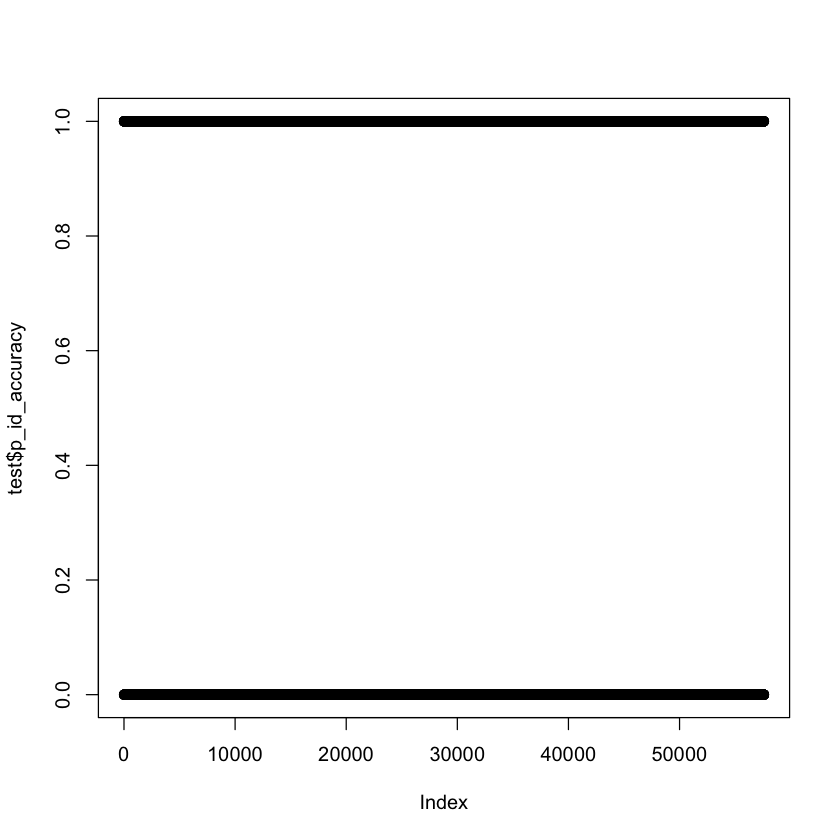

In [29]:
plot(test$p_id_accuracy)

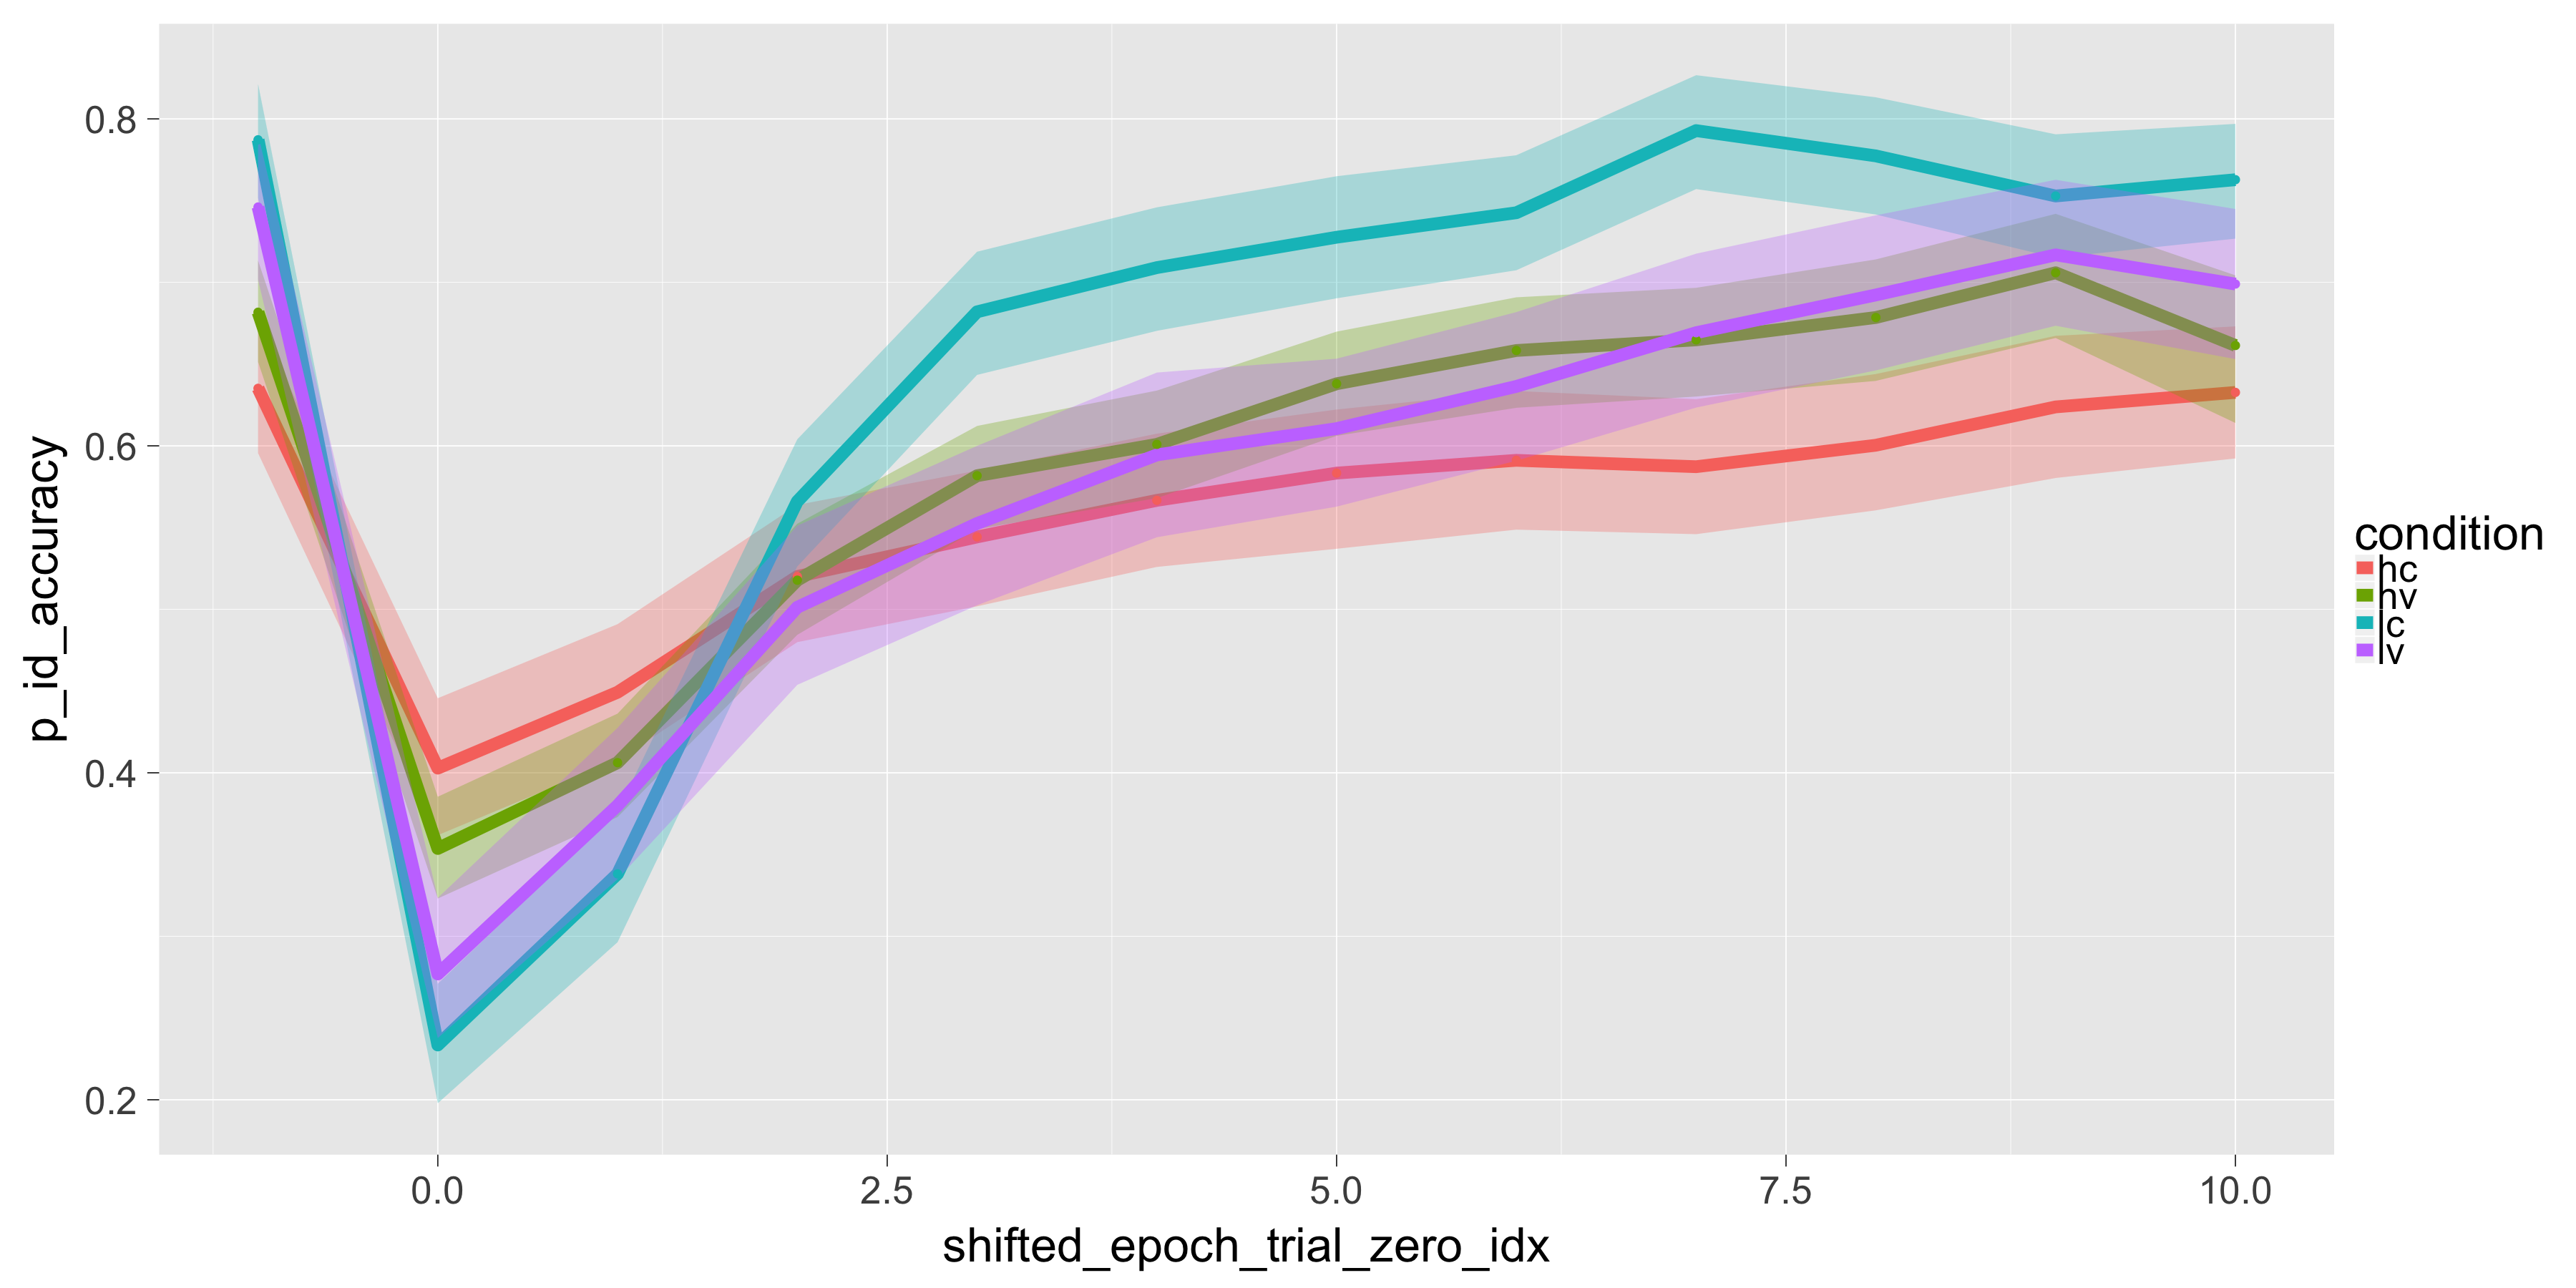

In [30]:
#tc for all conditions 
options(repr.plot.width=30, repr.plot.height=15)

ggplot(subset(test, (shifted_epoch_trial_zero_idx <= 10 & shifted_epoch_trial_zero_idx > -2 & epoch_n > 1)), aes(shifted_epoch_trial_zero_idx, p_id_accuracy, col=condition)) + 
stat_summary(fun.data = "mean_cl_boot", geom = "smooth", size=5, aes(fill=condition), alpha=0.3) +  stat_summary(fun.y = mean, geom = "point", size=3) + 
theme_gray(40) 
# + scale_x_continuous(breaks = seq(-2, 10, 1)) + scale_y_continuous(breaks=seq(0.2,.9, .1)) + 
# geom_vline(xintercept = 0, size=2, alpha=0.5)

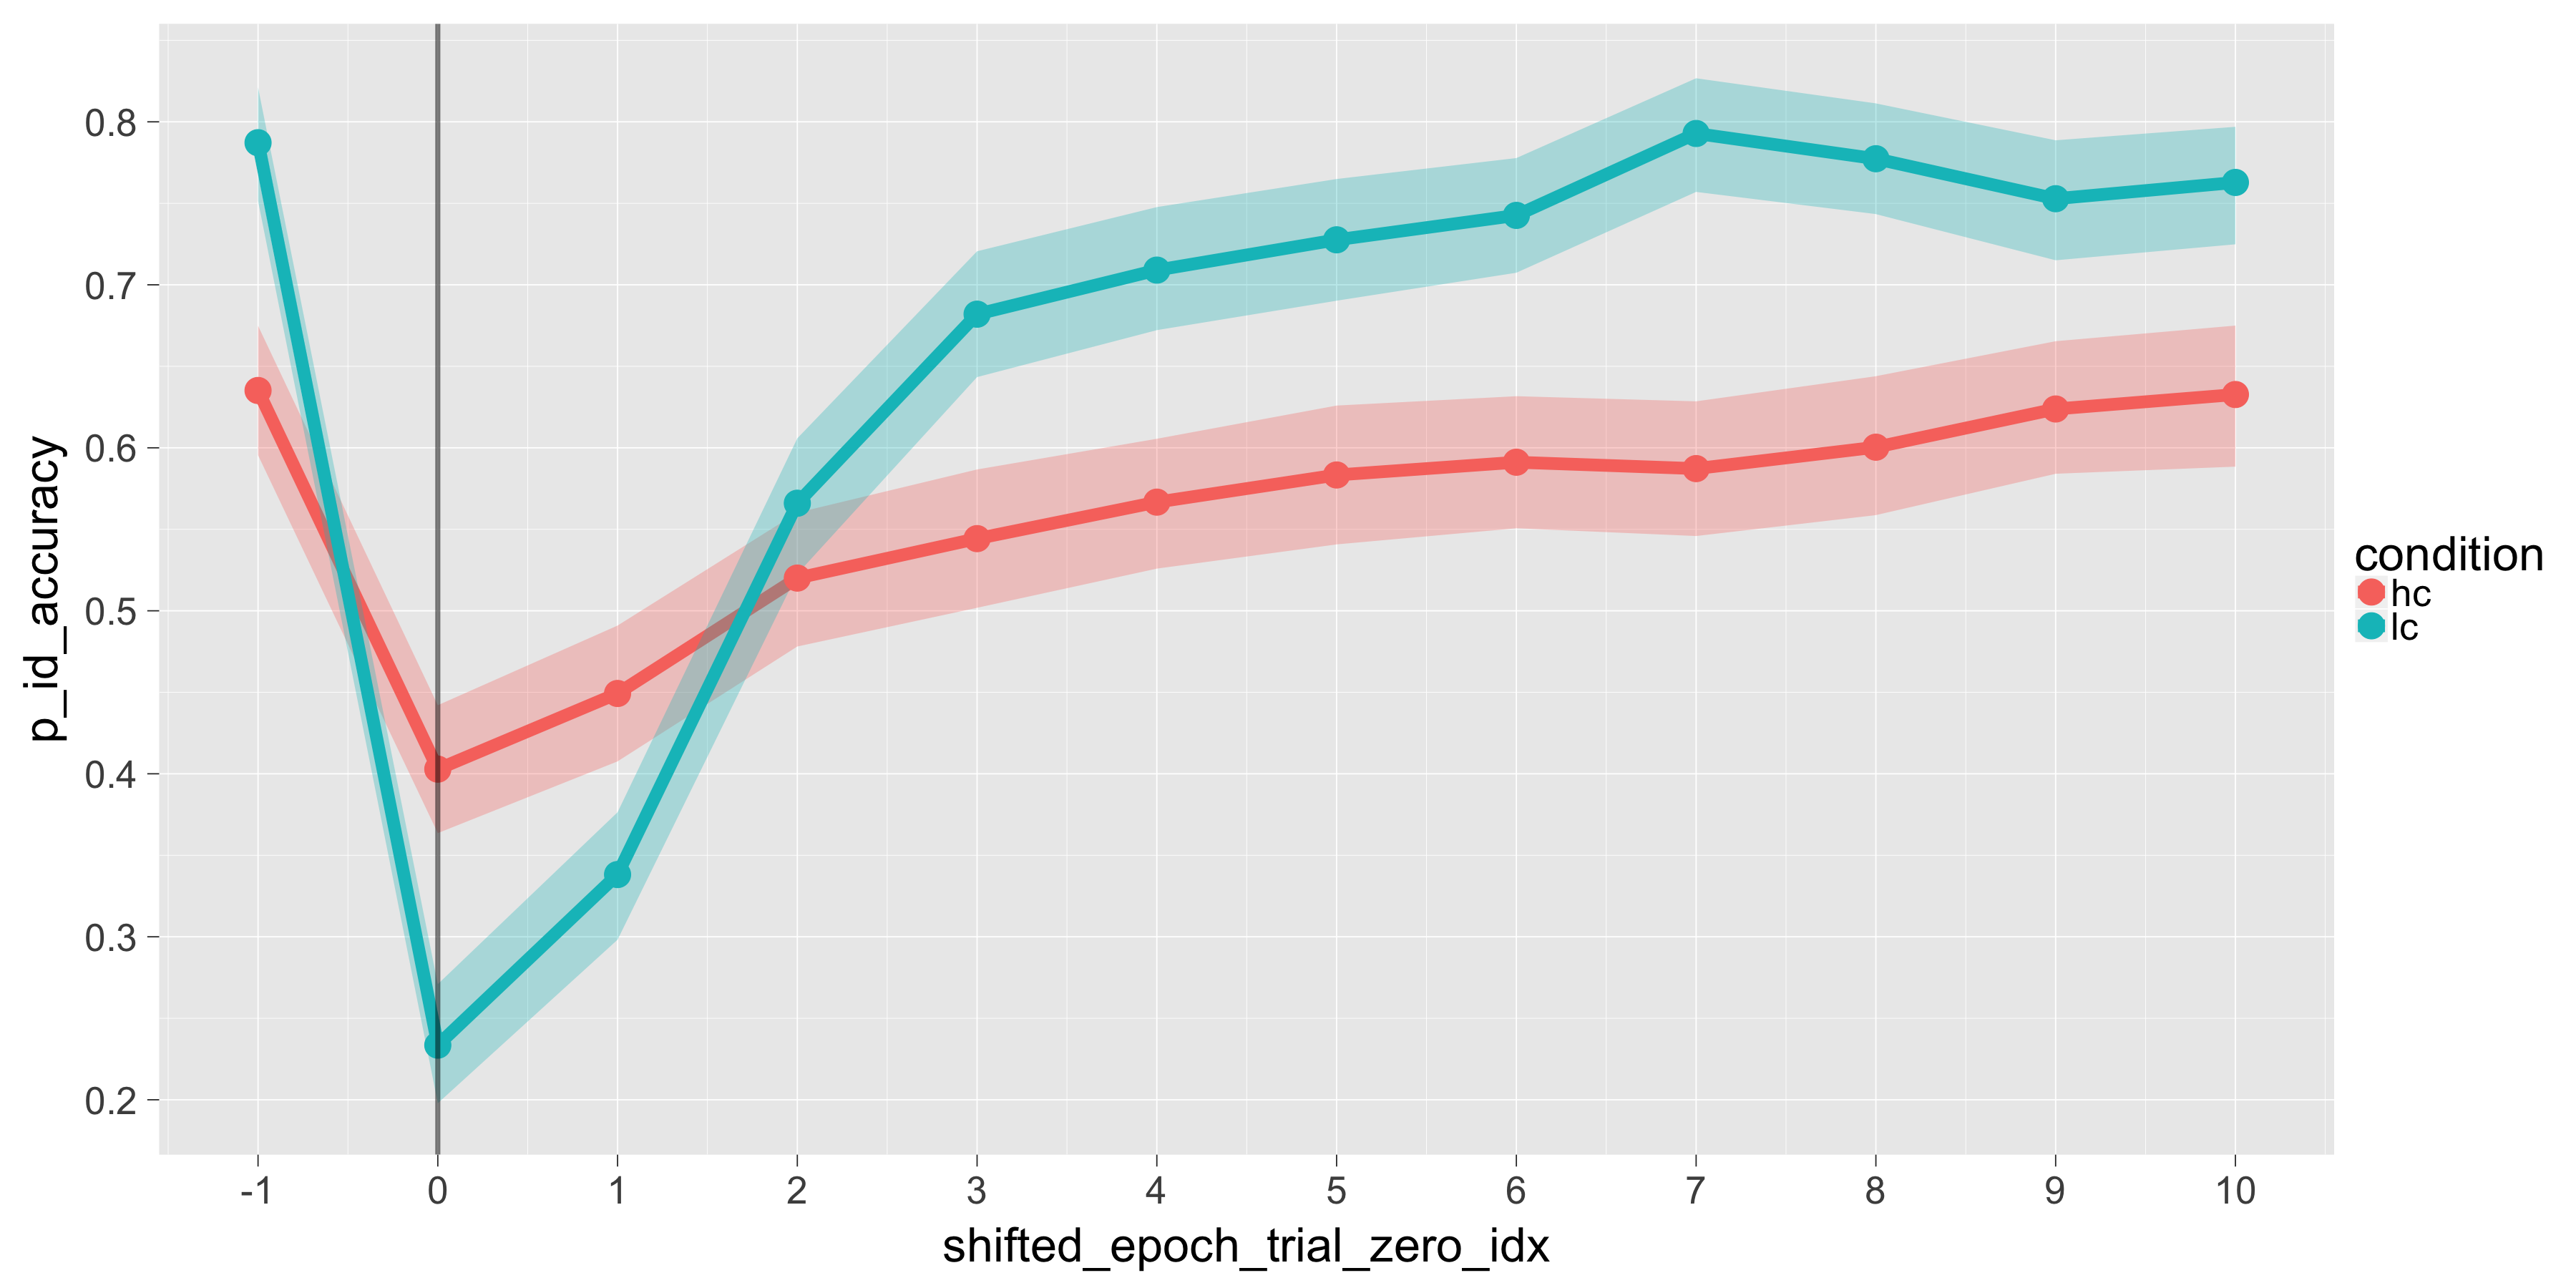

In [32]:
ggplot(subset(test, (shifted_epoch_trial_zero_idx <= 10 & shifted_epoch_trial_zero_idx > -2 & epoch_n > 1 & (condition == 'hc'| condition == 'lc'))), aes(shifted_epoch_trial_zero_idx, p_id_accuracy, col=condition)) + 
stat_summary(fun.data = "mean_cl_boot", geom = "smooth", size=5, aes(fill=condition), alpha=0.3) + stat_summary(fun.data = "mean_cl_boot", geom = "point", size=10) +
theme_gray(40)  + scale_x_continuous(breaks = seq(-2, 10, 1)) + scale_y_continuous(breaks=seq(0.2,.9, .1)) + 
geom_vline(xintercept = 0, size=2, alpha=0.5)

Warning message:
“Computation failed in `stat_summary()`:
object 'median_cl_boot' of mode 'function' was not found”

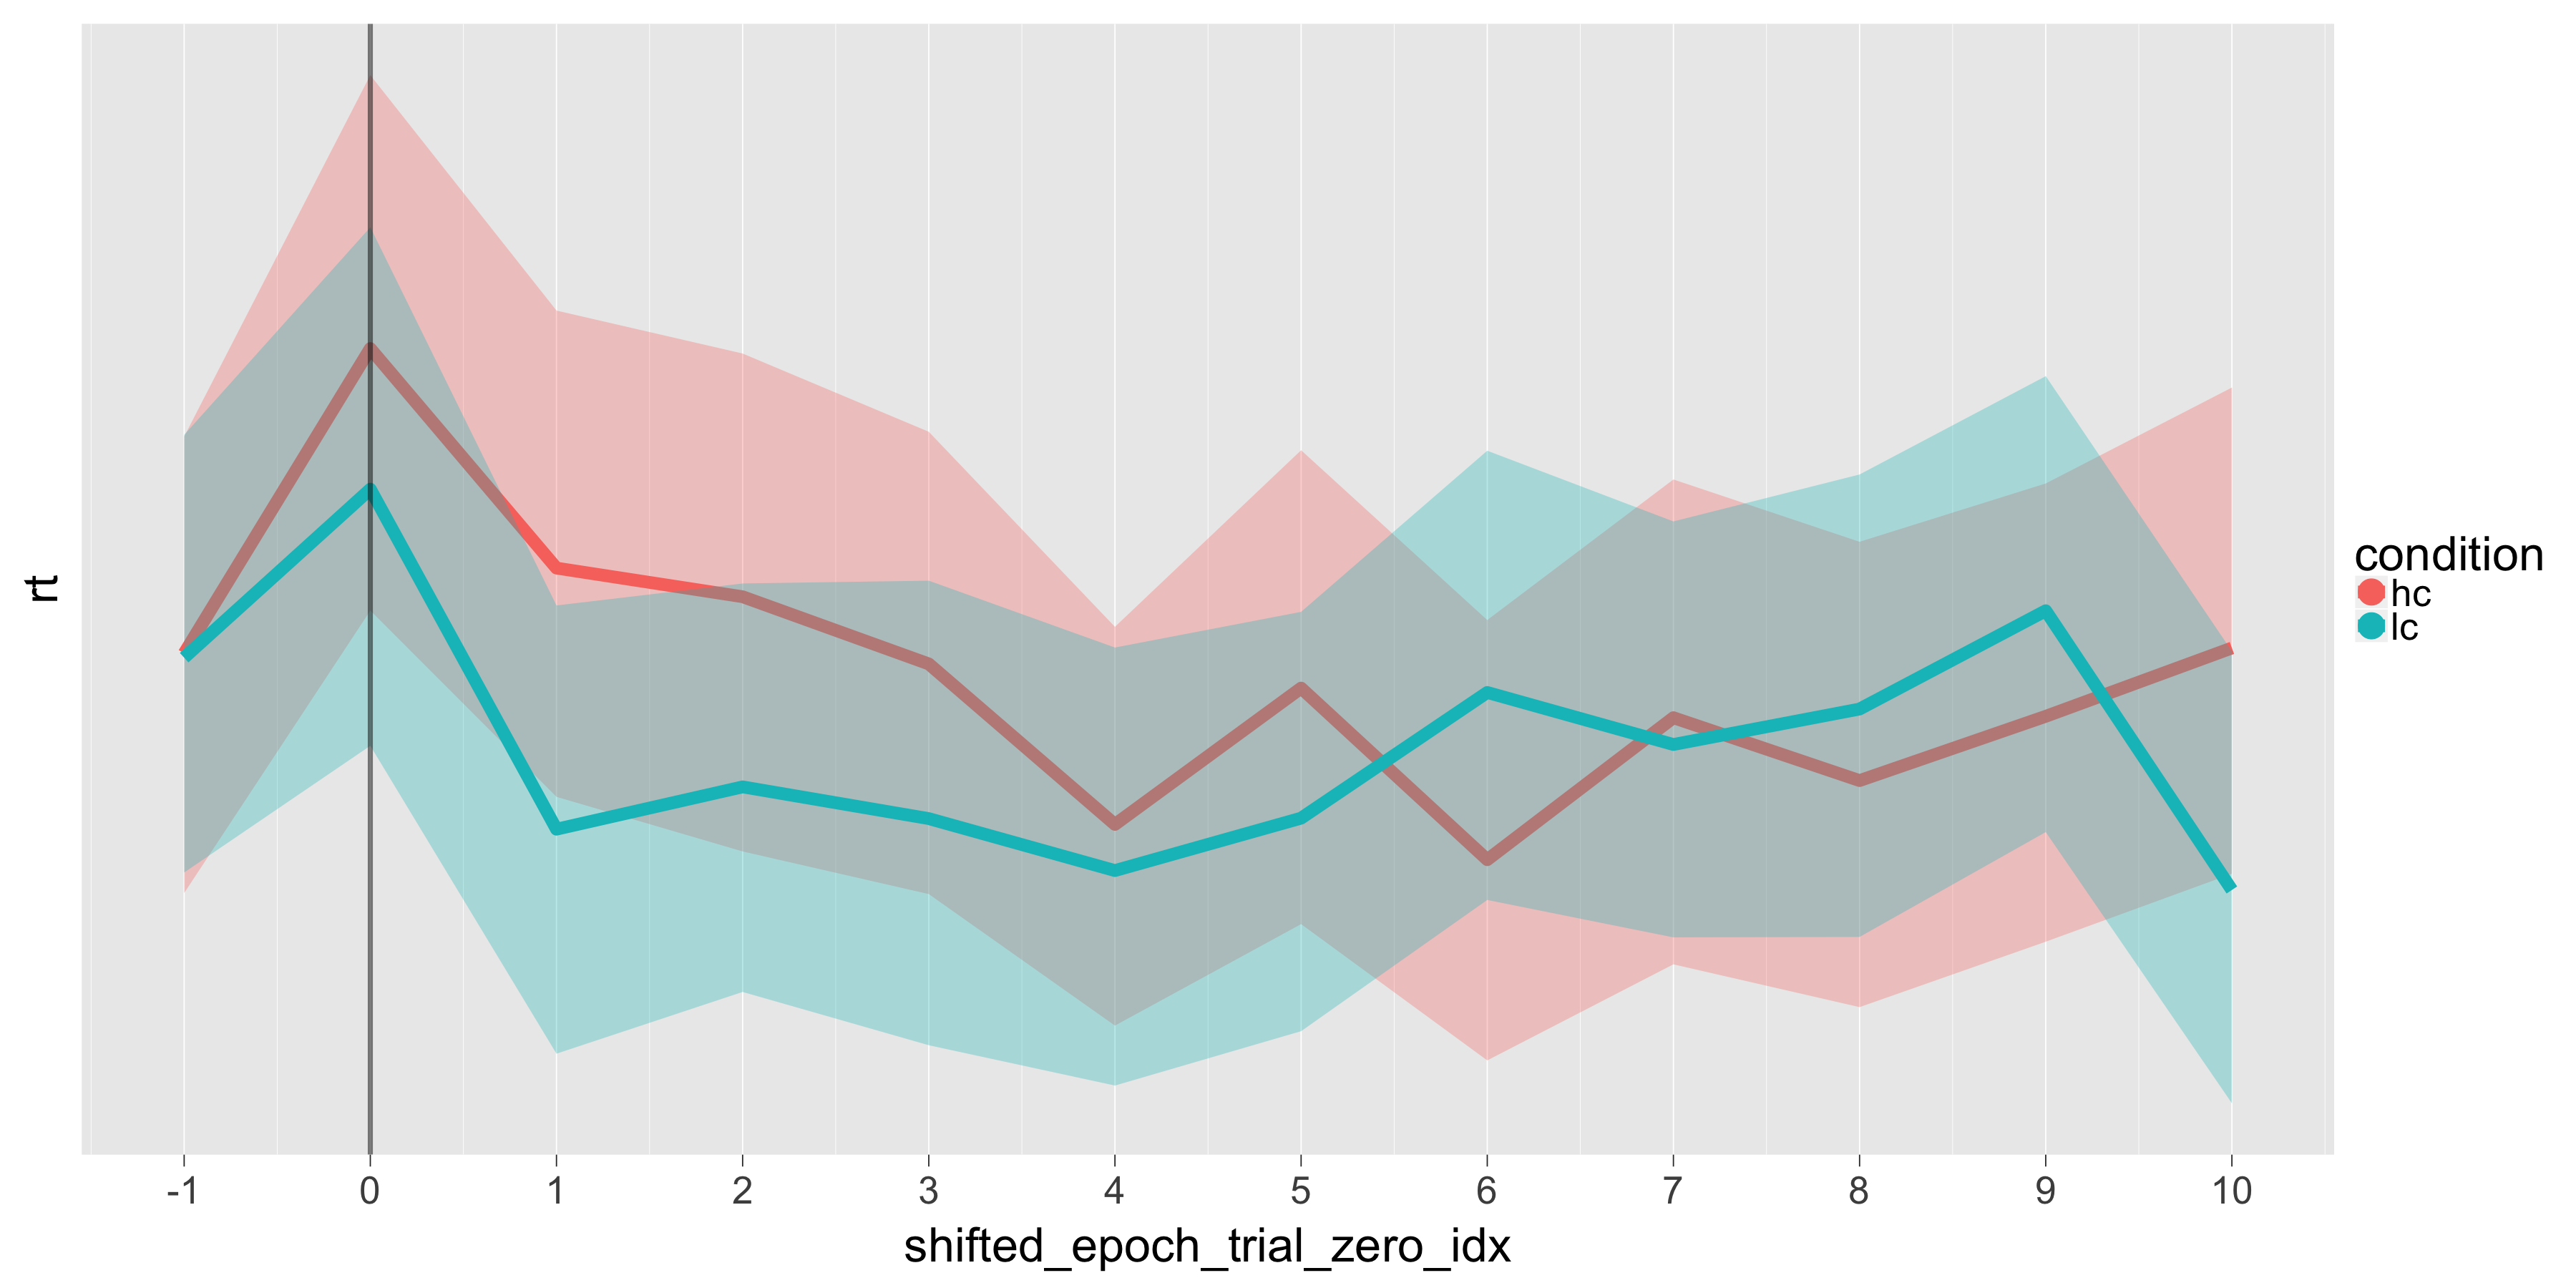

In [35]:
ggplot(subset(test, (shifted_epoch_trial_zero_idx <= 10 & shifted_epoch_trial_zero_idx > -2 & epoch_n > 1 & (condition == 'hc'| condition == 'lc'))), aes(shifted_epoch_trial_zero_idx, rt, col=condition)) + 
stat_summary(fun.data = "mean_cl_boot", geom = "smooth", size=5, aes(fill=condition), alpha=0.3) + stat_summary(fun.data = "median_cl_boot", geom = "point", size=10) +
theme_gray(40)  + scale_x_continuous(breaks = seq(-2, 10, 1)) + scale_y_continuous(breaks=seq(0.2,.9, .1)) + 
geom_vline(xintercept = 0, size=2, alpha=0.5)

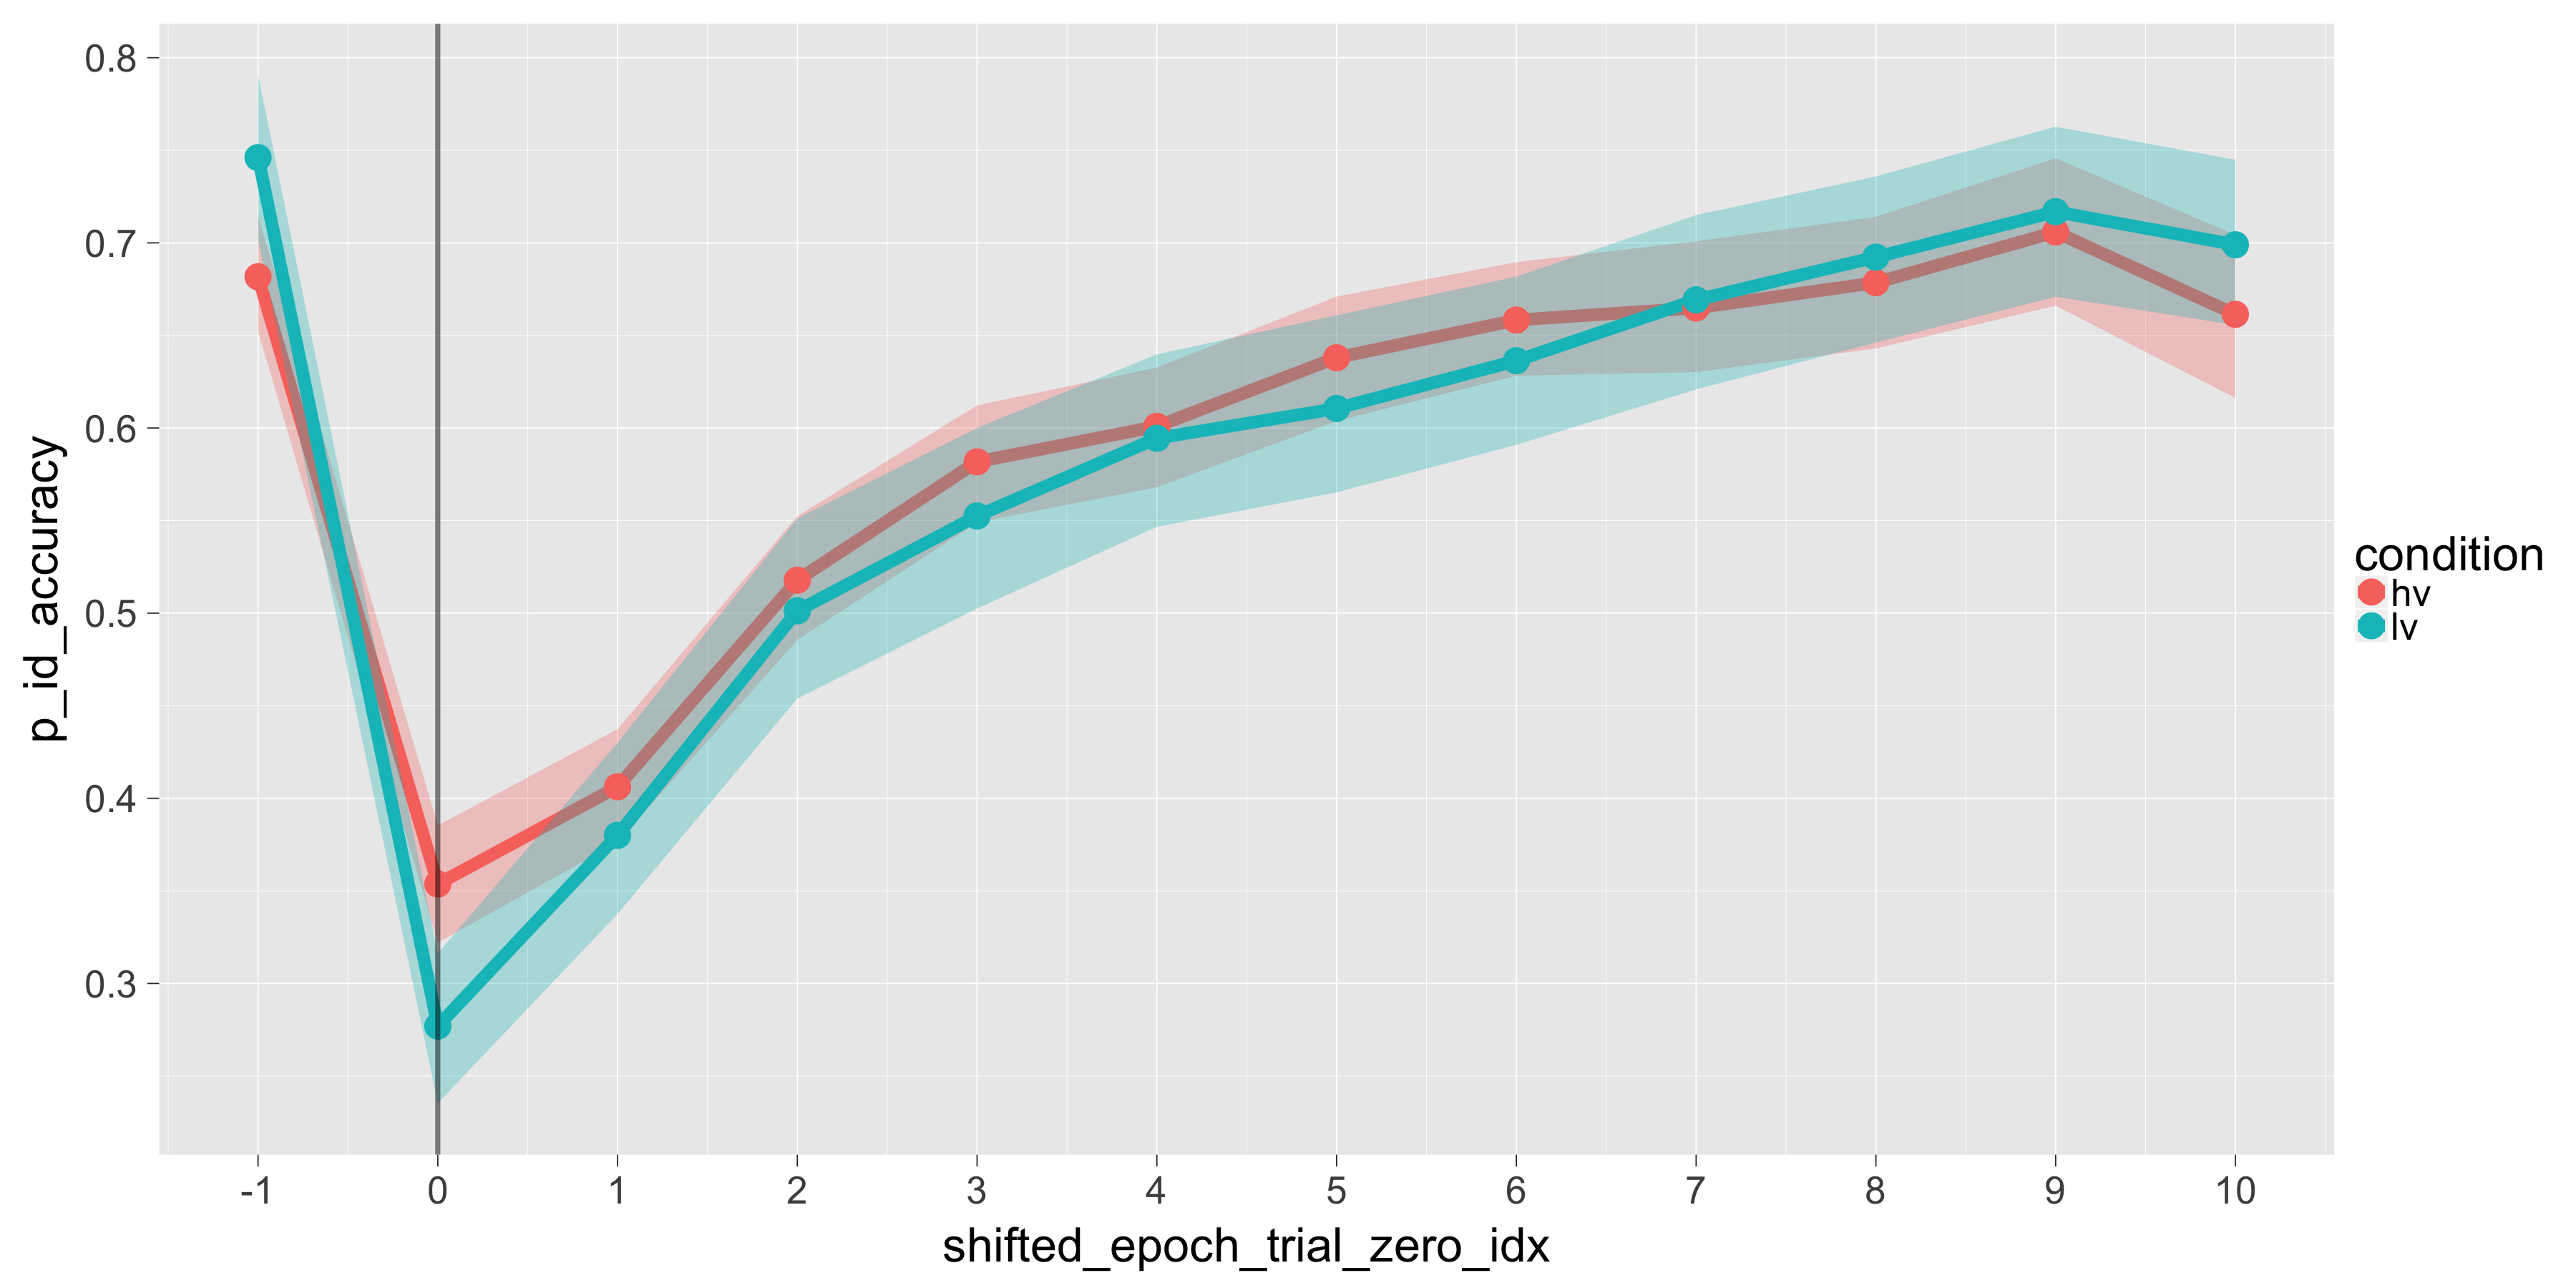

In [33]:
ggplot(subset(test, (shifted_epoch_trial_zero_idx <= 10 & shifted_epoch_trial_zero_idx > -2 & epoch_n > 1 & (condition == 'hv'| condition == 'lv'))), aes(shifted_epoch_trial_zero_idx, p_id_accuracy, col=condition)) + 
stat_summary(fun.data = "mean_cl_boot", geom = "smooth", size=5, aes(fill=condition), alpha=0.3) + stat_summary(fun.data = "mean_cl_boot", geom = "point", size=10) +
theme_gray(40)  + scale_x_continuous(breaks = seq(-2, 10, 1)) + scale_y_continuous(breaks=seq(0.2,.9, .1)) + 
geom_vline(xintercept = 0, size=2, alpha=0.5)

In [ ]:
ggplot(subset(test, (shifted_epoch_trial <= 10 & shifted_epoch_trial > -2 & epoch_n > 1 & (condition == 'hv'| condition == 'lv'))), aes(shifted_epoch_trial, rt, col=condition)) + 
stat_summary(fun.data = "mean_cl_boot", geom = "smooth", size=5, aes(fill=condition), alpha=0.3) + stat_summary(fun.data = "mean_cl_boot", geom = "point", size=10) +
theme_gray(40)  + scale_x_continuous(breaks = seq(-2, 10, 1)) + scale_y_continuous(breaks=seq(0.2,.9, .1)) + 
geom_vline(xintercept = 0, size=2, alpha=0.5)

In [ ]:
options(repr.plot.width=30, repr.plot.height=15)

ggplot(subset(test, (shifted_epoch_trial <= 10 & shifted_epoch_trial > -5 & epoch_n > 1)), aes(shifted_epoch_trial, rt, col=condition)) + 
stat_summary(fun.data = "mean_cl_boot", geom = "smooth", size=5, aes(fill=condition), alpha=0.3) + stat_summary(fun.data = "mean_cl_boot", geom = "point", size=10) +
theme_gray(40)  + scale_x_continuous(breaks = seq(-2, 10, 1)) + scale_y_continuous(breaks=seq(0.2,.9, .1)) + 
geom_vline(xintercept = 0, size=2, alpha=0.5) 

In [ ]:
sample <- subset(test, condition == 'lc'& ID == 761 & repeat_trial < 300)

In [ ]:
ggplot(sample, aes(repeat_trial, p_id_accuracy)) + geom_point(size=3, col='blue')+ 
geom_vline(xintercept=which(sample$cp_with_slow_fast == 1), alpha=0.5, size = 1.5) + theme_gray(30)

In [ ]:
ggplot(sample, aes(repeat_trial, rt)) + geom_line(size=3, col='blue')+ 
geom_vline(xintercept=which(sample$cp_with_slow_fast == 1), alpha=0.5, size = 1.5) + theme_gray(30)

In [ ]:
epoch_df <- subset(clean_df, epoch_trial <= 10) 

# epoch_df[epoch_df$epoch_trial <= 5, 'timepoint'] = 1
# epoch_df[epoch_df$epoch_trial > 5, 'timepoint'] = 2

epoch_df[epoch_df$condition == 'hc', 'conflict'] = 'high'
epoch_df[epoch_df$condition == 'lc', 'conflict'] = 'low'
epoch_df[epoch_df$condition == 'hc', 'vol'] = 'mod'
epoch_df[epoch_df$condition == 'lc', 'vol'] = 'mod'

epoch_df[epoch_df$condition == 'hv', 'vol'] = 'high'
epoch_df[epoch_df$condition == 'lv', 'vol'] = 'low'
epoch_df[epoch_df$condition == 'hv', 'conflict'] = 'mod'
epoch_df[epoch_df$condition == 'lv', 'conflict'] = 'mod'

epoch_df$conflict <- as.factor(epoch_df$conflict)
epoch_df$vol <- as.factor(epoch_df$vol)

epoch_df$conflict <- relevel(epoch_df$conflict, ref = "low")
epoch_df$vol <- relevel(epoch_df$vol, ref = "low")

epoch_df$condition <- relevel(epoch_df$condition, ref = "lc")

In [ ]:
head(epoch_df)

In [ ]:
write.csv(test, paste0(agg_data_path, 'clean_df.csv'),row.names=FALSE)